# $D^0 \to K^0_Sπ^+π^-$ with Mixing

We will fit 

$$
D^0 \to K^0_S \pi^+\pi^-
$$

decays generated with the following intermediate resonances:
- $D^0 \to K^0_S \rho(770)$
- $D^0 \to K^{*-}\pi^+$

In addition we add mixing, meaning that $D^0$ oscillates to $\bar{D}^0$, which subsequently decays with a charged-conjugate decay model, depending on time:

$$
|\mathcal{A}(t)|^2 = \frac{1}{4}\left|\mathcal{A}_{D^0} + \frac{q}{p}\mathcal{A}_{\bar{D}^0}\right|^2 \psi_+(t) + 
                     \frac{1}{4}\left|\mathcal{A}_{D^0} - \frac{q}{p}\mathcal{A}_{\bar{D}^0}\right|^2 \psi_-(t) + 
                     2 \Re{\left((\mathcal{A}_{D^0} + \frac{q}{p}\mathcal{A}_{\bar{D}^0})(\mathcal{A}_{D^0} - \frac{q}{p}\mathcal{A}_{\bar{D}^0})^*\psi_i(t)\right)},
$$

with

$$
\begin{align*}
\psi_+(t) &= e^{ -(1+y)\frac{t}{\tau} }\\
\psi_-(t) &= e^{ -(1-y)\frac{t}{\tau} }\\
\psi_i(t) &= e^{ -(1+ix)\frac{t}{\tau} }\\
\end{align*}
$$

Import modules

In [1]:
# import NumPy
import numpy as np
# Import Tensorflow
import tensorflow as tf
# Import AmpliTF modules
import amplitf.interface as atfi
import amplitf.kinematics as atfk
import amplitf.dynamics as atfd
import amplitf.likelihood as atfl
import amplitf.mixing as atfm
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace
from amplitf.phasespace.decaytime_phasespace import DecayTimePhaseSpace
from amplitf.phasespace.combined_phasespace import CombinedPhaseSpace
#from amplitf.mixing import psip, psim, psii, mixing_density

# Import TFA modules
import tfa.toymc as tft
import tfa.plotting as tfp
import tfa.optimisation as tfo

# Import plotting module
import matplotlib.pyplot as plt

2024-10-23 21:56:25.915305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Set the number of events to generate and the number of normalisation point to calculate the integral of the likelihood

In [2]:
ntoys = 100000  # Number of points to generate
nnorm = 1000000  # Number of normalisation points

Now define some constants

In [3]:
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)

# Resonances
mkst = atfi.const(lp.Kst_892_0.mass/1000)
wkst = atfi.const(lp.Kst_892_0.width/1000)
mrho = atfi.const(lp.rho_770_0.mass/1000)
wrho = atfi.const(lp.rho_770_0.width/1000)

# Blatt-Weisskopf radii for Breit-Wigner lineshape
rd = atfi.const(5.0)
rr = atfi.const(1.5)

The mixing parameters

In [4]:
tdz = atfi.const(1.)
x_mix = atfi.const(0.)#atfi.const(0.004)
y_mix = atfi.const(0.0)#atfi.const(0.0064)
qop_mix = atfi.const(1)
phi_mix = atfi.const(0)
qoverp = atfi.complex( qop_mix * atfi.cos(phi_mix), 
                       qop_mix * atfi.sin(phi_mix) )

and a class to deal with three-body Dalitz phase-space

In [5]:
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

Add a class to deal with the decay time

In [6]:
tphsp = DecayTimePhaseSpace(tdz)

And the combined phase-space

In [7]:
c_phsp = CombinedPhaseSpace(phsp,tphsp)

## Phasespace
Let's study the phasespace and the value of the functions on it

In [8]:
unfi_sample = c_phsp.unfiltered_sample(10000,1.0e-20)
comb_sample = c_phsp.filter(unfi_sample)

Plot the invariant masses and the decay time

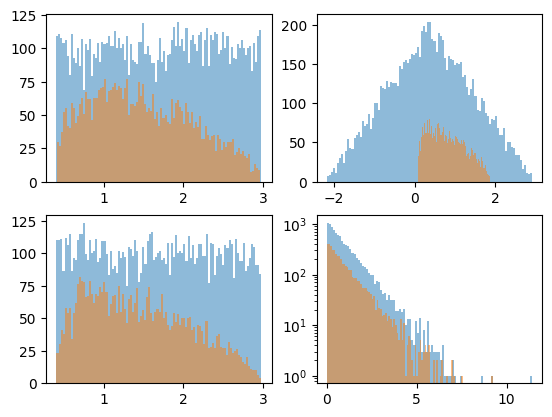

In [9]:
fig, ax = plt.subplots(2,2)
_ = ax[0][0].hist( np.array(c_phsp.phsp1.m2ab(c_phsp.data1(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[0][0].hist( np.array(c_phsp.phsp1.m2ab(c_phsp.data1(comb_sample)) ),bins=100, alpha=0.5)
_ = ax[1][0].hist( np.array(c_phsp.phsp1.m2bc(c_phsp.data1(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[1][0].hist( np.array(c_phsp.phsp1.m2bc(c_phsp.data1(comb_sample)) ),bins=100, alpha=0.5)
_ = ax[0][1].hist( np.array(c_phsp.phsp1.m2ac(c_phsp.data1(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[0][1].hist( np.array(c_phsp.phsp1.m2ac(c_phsp.data1(comb_sample)) ),bins=100, alpha=0.5)
_ = ax[1][1].hist( np.array(c_phsp.phsp2.t(c_phsp.data2(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[1][1].hist( np.array(c_phsp.phsp2.t(c_phsp.data2(comb_sample)) ),bins=100, alpha=0.5)
ax[1][1].set_yscale('log')

## Model
Below there is a function to define the model, allowing to switch on and off specific components.

In [10]:
from context import models
from models.d02kspipi import simple, simple_model_mix

In [11]:
def model(x):
# 
    m2ab = phsp.m2ab(x)
    m2bc = phsp.m2bc(x)
    m2ac = phsp.m2ac(x)

    hel_ab = atfd.helicity_amplitude(phsp.cos_helicity_ab(x), 1)
    hel_bc = atfd.helicity_amplitude(phsp.cos_helicity_bc(x), 1)
    hel_ac = atfd.helicity_amplitude(phsp.cos_helicity_ac(x), 1)

    bw1 = atfd.breit_wigner_lineshape(m2ab, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw2 = atfd.breit_wigner_lineshape(m2bc, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw3 = atfd.breit_wigner_lineshape(m2ac, mrho, wrho, mpi, mpi, mkz, md, rd, rr, 1, 1)

    def _model(a1r, a1i, a2r, a2i, a3r, a3i, switches=4 * [1]):

        a1 = atfi.complex(a1r, a1i)
        a2 = atfi.complex(a2r, a2i)
        a3 = atfi.complex(a3r, a3i)

        ampl = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0)
        )

        if switches[0]:
            ampl += a1 * bw1 * hel_ab
        if switches[1]:
            ampl += a2 * bw2 * hel_bc
        if switches[2]:
            ampl += a3 * bw3 * hel_ac
        if switches[3]:
            ampl += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0)
            )

        return atfd.density(ampl)

    return _model


In [12]:
def model_mix(x):

    # DZ - MIXING MODEL
    
    # CACHED VARIABLES
    m2ab = c_phsp.phsp1.m2ab(x)
    m2bc = c_phsp.phsp1.m2bc(x)
    m2ac = c_phsp.phsp1.m2ac(x)

    hel_ab = atfd.helicity_amplitude(c_phsp.phsp1.cos_helicity_ab(x), 1)
    hel_bc = atfd.helicity_amplitude(c_phsp.phsp1.cos_helicity_bc(x), 1)
    hel_ac = atfd.helicity_amplitude(c_phsp.phsp1.cos_helicity_ac(x), 1)

    bw1 = atfd.breit_wigner_lineshape(m2ab, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw2 = atfd.breit_wigner_lineshape(m2bc, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw3 = atfd.breit_wigner_lineshape(m2ac, mrho, wrho, mpi, mpi, mkz, md, rd, rr, 1, 1)

    def _model(#a1r, a1i, a2r, a2i, a3r, a3i,
               x_mix_par, y_mix_par,# qop_mag, qop_pha, 
               switches=4 * [1]):

        tep = atfm.psip(c_phsp.phsp2.t(c_phsp.data2(x)), y_mix_par, tdz)
        tem = atfm.psim(c_phsp.phsp2.t(c_phsp.data2(x)), y_mix_par, tdz)
        tei = atfm.psii(c_phsp.phsp2.t(c_phsp.data2(x)), x_mix_par, tdz)
        # qoverp_par = atfi.complex(qop_mag * atfi.cos(qop_pha), 
        #                           qop_mag * atfi.sin(qop_pha))

        a1r, a1i, a2r, a2i, a3r, a3i = atfi.const(1.0), atfi.const(0.0), atfi.const(0.5), atfi.const(0.0), atfi.const(2.0), atfi.const(0.0)
        a1 = atfi.complex(a1r, a1i)
        a2 = atfi.complex(a2r, a2i)
        a3 = atfi.complex(a3r, a3i)

        # D0 AMPLITUDE
        ampl_dz = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0)
        )

        if switches[0]:
            ampl_dz += a1 * bw1 * hel_ab
        if switches[1]:
            ampl_dz += a2 * bw2 * hel_bc
        if switches[2]:
            ampl_dz += a3 * bw3 * hel_ac
        if switches[3]:
            ampl_dz += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0)
            )

        # D0bar AMPLITUDE: exchange a <--> c
        ampl_dzb = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0)
        )

        if switches[0]:
            ampl_dzb += a1 * bw2 * hel_bc
        if switches[1]:
            ampl_dzb += a2 * bw1 * hel_ab
        if switches[2]:
            ampl_dzb += -a3 * bw3 * hel_ac
        if switches[3]:
            ampl_dzb += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0)
            )

        # MIXING
        dens = atfm.mixing_density(ampl_dz, ampl_dzb, qoverp, tep, tem, tei)        
        return dens

    return _model

In [13]:
from context import models
from models.d02kspipi import simple_model_mix

**TODO**: The syntax above does not work for the mixing class I though because it multiplies at a certain point a function to a tensor.
I should try to define a full model with mixing as a function and then think how this can be generalised in the code.

## Toy MC Model
The model of the toy MC has all the components on by default. By means of the `switches` flag, some of them can be turned off to see the effects on the fit.

In [14]:
def toymc_model_simple(x, switches=4 * [1]):
    return simple(x, phsp, 
                  md, mpi, mkz, mkst, wkst, 
                  mrho, wrho, rd, rr)(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.const(0.5),
        a2i=atfi.const(0.0),
        a3r=atfi.const(2.0),
        a3i=atfi.const(0.0),
    )

In [15]:
def toymc_model(x, switches=4 * [1]):
    return model_mix(x)(
        switches=switches,
        # a1r=atfi.const(1.0),
        # a1i=atfi.const(0.0),
        # a2r=atfi.const(0.5),
        # a2i=atfi.const(0.0),
        # a3r=atfi.const(2.0),
        # a3i=atfi.const(0.0),
        x_mix_par=atfi.const(0.004),
        y_mix_par=atfi.const(0.006),
        # qop_mag = atfi.const(1),
        # qop_pha = atfi.const(0)
    )

In [25]:
def toymc_model_mix(x, switches=4 * [1]):
    return simple_model_mix(x, c_phsp, tdz,
                  md, mpi, mkz, mkst, wkst, 
                  mrho, wrho, rd, rr)(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.const(0.5),
        a2i=atfi.const(0.0),
        a3r=atfi.const(2.0),
        a3i=atfi.const(0.0),
        x_mix_par=atfi.const(0.004),
        y_mix_par=atfi.const(0.006),
        qop_mag = atfi.const(1),
        qop_pha = atfi.const(0)
    )

In [28]:
toy = toymc_model_mix(comb_sample)

TypeError: tf.Tensor(
[25.20632585  7.00116321 18.14056639 ... 16.98540521  0.75138658
  8.70412583], shape=(4718,), dtype=float64) argument after ** must be a mapping, not list

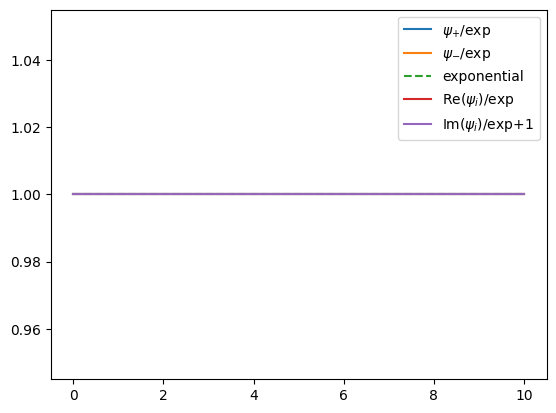

In [18]:
t_pl = np.linspace(0,10,1000)
plt.plot( t_pl, atfm.psip(t_pl, x_mix, tdz)/np.exp(-t_pl/tdz), label=r'$\psi_{+}$/exp' )
plt.plot( t_pl, atfm.psim(t_pl, x_mix, tdz)/np.exp(-t_pl/tdz), label=r'$\psi_{-}$/exp' )
plt.plot( t_pl, np.ones(len(t_pl)), label='exponential', linestyle='dashed' )
plt.plot( t_pl, np.real(atfm.psii(t_pl, y_mix, tdz))/np.exp(-t_pl/tdz), label=r'Re($\psi_{i}$)/exp' )
plt.plot( t_pl, 1+np.imag(atfm.psii(t_pl, y_mix, tdz))/np.exp(-t_pl/tdz), label=r'Im($\psi_{i}$)/exp+1' )
#plt.yscale('log')
plt.legend()

## Likelihood

The Negative Log Likelihood

In [19]:
# TF graph for unbinned negalite log likelihood (the quantity to be minimised)
def nll(data, norm):
    data_model = toymc_model_mix(data)
    norm_model = toymc_model_mix(norm)

    @atfi.function
    def _nll(pars):
        return atfl.unbinned_nll(data_model(**pars), atfl.integral(norm_model(**pars)))

    return _nll

## Samples

The samples to fit

In [20]:
toy_sample = tft.run_toymc(
    toymc_model_simple, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)

print(toy_sample)

  Updating maximum: 1e-20 -> 965.6594586473875. Starting over.
  Chunk 1, size=28035, total length=28035
  Chunk 2, size=28213, total length=56248
  Chunk 3, size=27810, total length=84058
  Chunk 4, size=28047, total length=112105
tf.Tensor(
[[2.16154964 0.83136817 0.55457417]
 [2.34764501 0.62602024 0.69095884]
 [0.82271754 2.7243062  0.22514162]
 ...
 [1.88876748 1.19411365 2.12886891]
 [1.31561998 2.28559173 1.34001987]
 [1.85165396 1.0306949  0.07050794]], shape=(100000, 3), dtype=float64)


and to calculate the integrals

In [21]:
norm_sample = c_phsp.uniform_sample(nnorm)

print(norm_sample)

tf.Tensor(
[[1.74509599 0.55178474 0.93041577]
 [0.70745321 2.28592108 0.84279442]
 [2.09667713 0.68456773 0.69772012]
 ...
 [0.65467603 2.21268788 2.7561724 ]
 [1.69145071 1.58966994 0.81602352]
 [2.16001644 0.97229214 0.52294982]], shape=(474016, 3), dtype=float64)


Beware that only approximately 1/2 of the events have been generated in the normalisation sample.

## Fit

We are now ready to run the fit. We define first the fit parameters:

In [22]:
pars = [
    tfo.FitParameter("a1r", 1.0, -10.0, 10.0),
    tfo.FitParameter("a1i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a2r", 0.5, -10.0, 10.0),
    tfo.FitParameter("a2i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a3r", 2.0, -10.0, 10.0),
    tfo.FitParameter("a3i", 0.0, -10.0, 10.0),
]
pars += [
    tfo.FitParameter("x_mix_par", 0.004, -0.02, 0.02),
    tfo.FitParameter("y_mix_par", 0.006, -0.02, 0.02),
    tfo.FitParameter("qop_mag", 1.0, 0.80, 1.20),
    tfo.FitParameter("qop_pha", 0.0, -0.60, 0.60),
]
fixed_pars = ['a1r','a1i','a2r','a2i','a3r','a3i','qop_mag','qop_pha']
for p in pars:
    if p.name in fixed_pars:
        p.fix()

In [23]:
for p in pars:
    print(p.name, p.floating())

a1r False
a1i False
a2r False
a2i False
a3r False
a3i False
x_mix_par True
y_mix_par True
qop_mag False
qop_pha False


and run Minuit

In [26]:
# Run MINUIT minimisation of the neg. log likelihood
result = tfo.run_minuit(nll(toy_sample, norm_sample), pars)
print(result)
cov = result['covariance'] if 'covariance' in result.keys() else None
if cov is None: print('COVARIANCE NOT VALID')

print(f"{result['time']/result['func_calls']} sec per function call")

fitted_pars = {p: atfi.const(v[0]) for p, v in result["params"].items()}

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object is not callable

Define a function with the fitted model to calculate fit fractions and projections

In [20]:
def fitted_model(x, switches=4 * [1]):
    return model_mix(x)(**fitted_pars, switches=switches)

The fit fractions are calculated

In [21]:
ff = tfo.calculate_fit_fractions(fitted_model, norm_sample)
print(ff)

[0.21748904875456995, 0.053438924612002815, 0.4013427428839789, 0.4349649003012873]


## Plotting

For plotting the results we generate a sample according to the model and we overlay it to the data

In [59]:
fitted_sample = tft.run_toymc(
    fitted_model, c_phsp, nnorm, maximum=1.0e-20, chunk=1000000, components=True
)

  Updating maximum: 1e-20 -> 943.4349181432742. Starting over.
  Chunk 1, size=14447, total length=14447
  Chunk 2, size=14402, total length=28849
  Chunk 3, size=14303, total length=43152
  Chunk 4, size=14651, total length=57803
  Chunk 5, size=14380, total length=72183
  Chunk 6, size=14543, total length=86726
  Chunk 7, size=14412, total length=101138
  Chunk 8, size=14542, total length=115680
  Chunk 9, size=14311, total length=129991
  Chunk 10, size=14601, total length=144592
  Chunk 11, size=14369, total length=158961
  Chunk 12, size=14507, total length=173468
  Chunk 13, size=14465, total length=187933
  Chunk 14, size=14221, total length=202154
  Chunk 15, size=14397, total length=216551
  Chunk 16, size=14432, total length=230983
  Chunk 17, size=14527, total length=245510
  Chunk 18, size=14392, total length=259902
  Chunk 19, size=14457, total length=274359
  Chunk 20, size=14434, total length=288793
  Chunk 21, size=14501, total length=303294
  Chunk 22, size=14354, tota

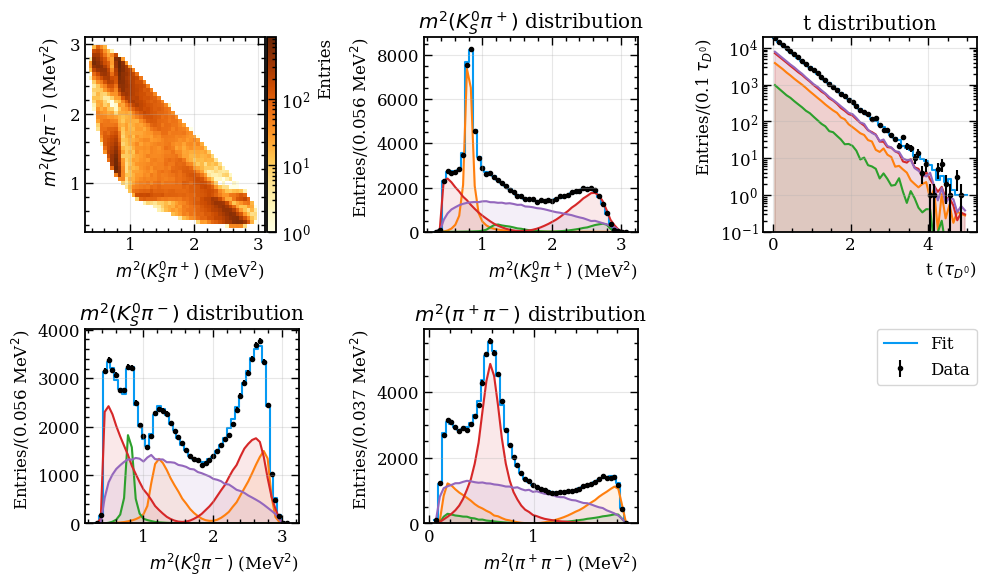

In [23]:
# Plot results
import matplotlib.pyplot as plt

tfp.set_lhcb_style(size=12, usetex=False)  # Adjust plotting style for LHCb papers
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))  # Single subplot on the figure

# Plot 1D histogram from the toy MC sample
tfp.plot_distr2d(
    toy_sample[:, 0],
    toy_sample[:, 1],
    bins=(50, 50),
    ranges=((0.3, 3.1), (0.3, 3.1)),
    fig=fig,
    ax=ax[0, 0],
    labels=(r"$m^2(K_S^0\pi^+)$", r"$m^2(K_S^0\pi^-)$"),
    units=("MeV$^2$", "MeV$^2$"),
    log=True,
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 0],
    fitted_sample[:, 0],
    cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[0, 1],
    label=r"$m^2(K_S^0\pi^+)$",
    units="MeV$^2$",
    legend=False
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 1],
    fitted_sample[:, 1],
    cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[1, 0],
    label=r"$m^2(K_S^0\pi^-)$",
    units="MeV$^2$",
    legend=False
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 2],
    fitted_sample[:, 2],
    cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0., 5),
    ax=ax[0, 2],
    label=r"t",
    units=r"$\tau_{D^0}$",
    log=True,
    legend=False
)

tfp.plot_distr1d_comparison(
    c_phsp.phsp1.m2ac(c_phsp.data1(toy_sample)),
    c_phsp.phsp1.m2ac(c_phsp.data1(fitted_sample)),
    cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0.05, 1.9),
    ax=ax[1, 1],
    label=r"$m^2(\pi^+\pi^-)$",
    units="MeV$^2$",
    legend_ax=ax[1,2]
)

# Show the plot
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)